In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import os
os.getcwd()
labels = pd.read_csv(r'../mlprojects/data/train.csv')
submission = pd.read_csv(r'../mlprojects/data/sample_submission.csv')
train_path = r'../mlprojects/data/train/train/'
test_path = r'../mlprojects/data/test/test/'

In [3]:
labels.head(6)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1


In [4]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [5]:
labels.groupby('has_cactus').size()

has_cactus
0     4364
1    13136
dtype: int64

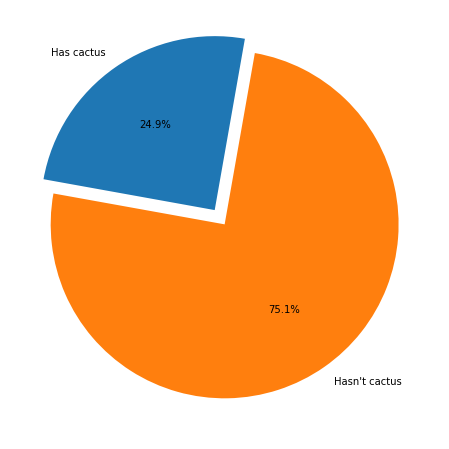

In [6]:
label = 'Has cactus', 'Hasn\'t cactus'
plt.figure(figsize=(8,8))
explode = (0.1, 0)
size = labels.groupby('has_cactus').size()
plt.pie(size, labels=label,explode=explode, autopct='%1.1f%%', shadow=False\
       , startangle=80);

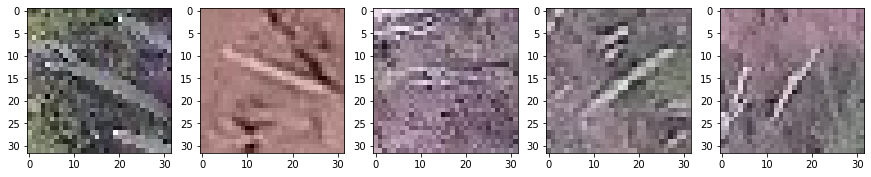

In [7]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

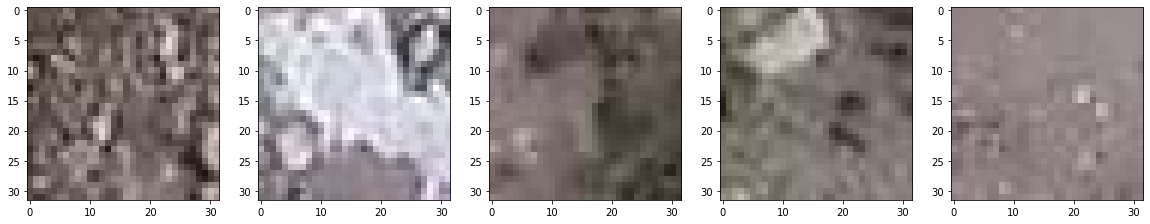

In [8]:
fig, ax = plt.subplots(1,5, figsize=(20,5))

for i, idx in enumerate(labels[labels['has_cactus'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[i].imshow(img.imread(path))

In [9]:
import numpy as np

def imshow(image, ax = None, title=None, normalize = True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std*image + mean
        image = np.clip(image, 0, 1)
        
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

In [10]:
class CactiDataset(Dataset):
    def __init__(self, data, path, transform=None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name, label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [11]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [12]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean, std)])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean, std)])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean, std)])

In [13]:
train, valid_data = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)

In [14]:
train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data, train_path, valid_transform )
test_data = CactiDataset(submission, test_path, test_transform )

In [15]:
#Hyperparametrs
epochs = 35
num_classes = 2
lr = 0.001
batch_size = 25

In [49]:
# Initialize device
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device

device(type='cuda', index=0)

In [17]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images
torch.Size([3, 32, 32])


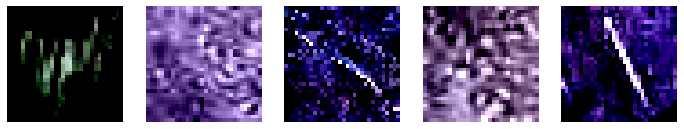

In [28]:
trainimage, trainlabel = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimage[i], ax=axe1, normalize=False)
    
print(trainimage[0].size())

In [51]:
# Create CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #x = F.relu(F.max_pool2d(self.conv2_drop(x, 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
       
        return x


In [52]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [56]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
%%time

# keeping track loss
train_losses = []
valid_losses = []

for epoch in range(1, epochs + 1):
    #keeping track training and validing loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        #move on tensors to GPU
        
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        #predict
        output = model(data)
        
        #calculate the loss
        loss = criterion(output, target)
        
        #backward
        loss.backward()
        
        #update our parameter
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        
    #validate model
    model.eval()
    
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        valid_loss += loss.item() * data.size(0)
        
        
    #calculate the average loss
    
    train_avg_loss = train_loss / len(train_loader.sampler)
    valid_avg_loss = valid_loss / len(valid_loader.sampler)    
    train_losses.append(train_avg_loss)
    valid_losses.append(valid_avg_loss)
        
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        
        
        
        
        
        

Epoch: 1 	Training Loss: 2523.603860 	Validation Loss: 273.552805
Epoch: 2 	Training Loss: 1578.238150 	Validation Loss: 215.633339
Epoch: 3 	Training Loss: 1227.176088 	Validation Loss: 186.451468
Epoch: 4 	Training Loss: 1098.532558 	Validation Loss: 163.476176
Epoch: 5 	Training Loss: 1005.417092 	Validation Loss: 150.139205
Epoch: 6 	Training Loss: 947.140413 	Validation Loss: 133.132372
Epoch: 7 	Training Loss: 820.029718 	Validation Loss: 143.553660
Epoch: 8 	Training Loss: 779.898715 	Validation Loss: 110.050689
Epoch: 9 	Training Loss: 815.035761 	Validation Loss: 106.279080
Epoch: 10 	Training Loss: 763.783629 	Validation Loss: 177.863120
Epoch: 11 	Training Loss: 758.159700 	Validation Loss: 111.721367
Epoch: 12 	Training Loss: 691.363996 	Validation Loss: 122.723744
Epoch: 13 	Training Loss: 728.401026 	Validation Loss: 116.307140
Epoch: 14 	Training Loss: 626.234987 	Validation Loss: 120.855973
Epoch: 15 	Training Loss: 698.796533 	Validation Loss: 123.217077
Epoch: 16 	Tra

In [60]:
model.eval()
#test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, label in valid_loader:
        images = images.to(device)
        label = label.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted==label).sum().item()
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 99.11428571428571 %


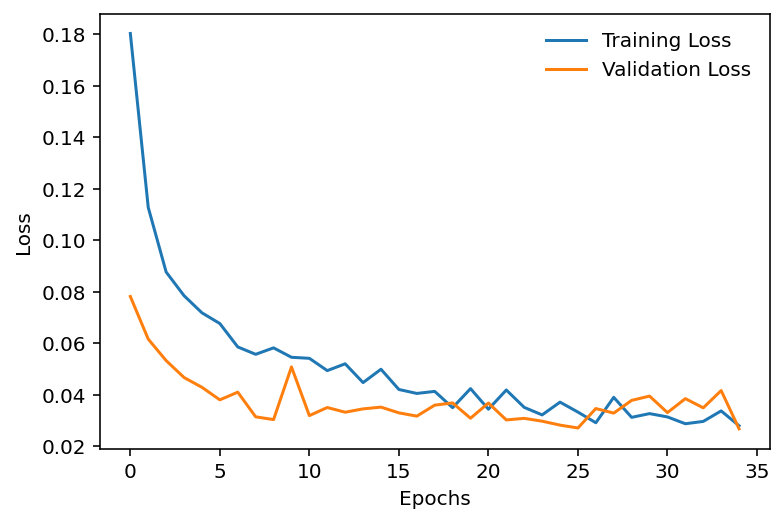

In [61]:
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)